In [4]:
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
import numpy as np
import torch
import cv2
import torch.nn as nn
import albumentations as A
import time
import copy
from sklearn.model_selection import KFold

In [5]:
def load_data(data_path):
    images = []
    labels = []

    for file in os.listdir(data_path):
        if file.endswith(".png") and not file.endswith("_L.png"):  
            # find images whose naming format is .png 
            img = cv2.imread(os.path.join(data_path, file))
            # convert the color space of the image from BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
            # read the corresponding label image whose naming format is _L.png
            label_img = cv2.imread(os.path.join(data_path, file[:-4] + "_L.png"))  
            label_img = cv2.cvtColor(label_img, cv2.COLOR_BGR2RGB)

            images.append(img)
            labels.append(label_img)

    return images, labels


In [6]:
batch_size = 16
num_epochs = 10
# define number of splits
n_splits = 5
# initialize KFold
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# set the path to the dataset folder
dataset_path = "Cam101"

# load the RGB values and class names from the label_colors.txt file
label_colors = {}
# open the label_colors.txt file and read its lines
with open(os.path.join(dataset_path, "label_colors.txt"), "r") as f:
    lines = f.readlines()
    for line in lines:
        # split the line into its values
        values = line.strip().split()
        # extract the RGB values from the line and convert them to integers  
        rgb = tuple(map(int, values[:3])) 
        # extract the label text from the line and join its values 
        label = " ".join(values[3:]) 
        # add the RGB value and label to the label_colors dictionary    
        label_colors[rgb] = label

# define the augmentation pipeline
train_augmentations = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RGBShift(p=0.5) ])

# define the augmentation pipeline for test data
test_augmentations = A.Compose([A.Resize(256, 256)])

# load traindata path
train_data_path = os.path.join(dataset_path, "train")
# load testdata path  
test_data_path = os.path.join(dataset_path, "test") 

# load training image and label
train_images, train_labels = load_data(train_data_path)
# load test image and label  
test_images, test_labels = load_data(test_data_path)  

# print the result
print("Number of training images:", len(train_images))
print("Number of training labels:", len(train_labels))
print("Number of testing images:", len(test_images))
print("Number of testing labels:", len(test_labels))

Number of training images: 90
Number of training labels: 90
Number of testing images: 11
Number of testing labels: 11


In [7]:
# define dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, augmentations=None, augmentations_multiplier=1):
        self.images = images
        self.labels = labels
        self.augmentations = augmentations
        # define the increase in data through data augmentation
        self.augmentations_multiplier = augmentations_multiplier  
    def __len__(self):
        # dataset length is scaled with augmentation multiplier
        return len(self.images) * self.augmentations_multiplier
    def __getitem__(self, idx):
        # modulo operation ensures that index is within bounds even with augmentation multiplier
        idx = idx % len(self.images)
        # fetch image and corresponding label
        image, label = self.images[idx], self.labels[idx]
        # apply augmentations if specified
        if self.augmentations:
            augmented = self.augmentations(image=image, mask=label)
            image, label = augmented['image'], augmented['mask']
        # adjust the image dimensions and standardize
        image = self._prepare_image(image)
        # convert the label to a single-channel tensor
        label = self._prepare_label(label)
        return image, label
    @staticmethod
    def _prepare_image(img):
        # transpose the image and normalize
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        img = torch.from_numpy(img) / 255.0
        return img
    @staticmethod
    def _prepare_label(lbl):
        # convert the label to a single-channel tensor
        lbl_single_channel = np.zeros(lbl.shape[:2], dtype=np.int64)
        for i, (r, g, b) in enumerate(label_colors.keys()):
            lbl_single_channel[(lbl == (r, g, b)).all(axis=2)] = i
        lbl = torch.from_numpy(lbl_single_channel)
        return lbl

In [8]:
# create the CustomDataset instances for training and testing
train_data = CustomDataset(train_images, train_labels, augmentations=train_augmentations, augmentations_multiplier=4)
test_data = CustomDataset(test_images, test_labels, augmentations=test_augmentations)

train_size = int(0.9 * len(train_data))
val_size = int(0.1 * len(train_data))
train_dataset, val_dataset = random_split(train_data, [train_size, val_size], generator=torch.Generator().manual_seed(0))


# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(label_colors)

In [9]:
class FCN16s(nn.Module):
    def __init__(self, num_classes):
        super(FCN16s, self).__init__()

        # VGG16-based feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 1x1 convolutional layers
        self.fcn32 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.fcn16 = nn.Conv2d(512, num_classes, kernel_size=1)
        
        # transposed convolutional layers
        self.up32 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.up16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, padding=8)

    def forward(self, x):
        # get the output from different layers of the VGG16 model.
        pool4 = self.features[:24](x)
        pool5 = self.features(x)
        
        # apply the 1x1 convolutional layers to the respective pooling layers to compute the score maps.
        fcn32 = self.fcn32(pool5)
        fcn16 = self.fcn16(pool4)
        
        # perform upsampling by the transposed convolutional layers.
        up32 = self.up32(fcn32)
        up16 = self.up16(fcn16 + up32)

        return up16

    
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        def upconv_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = conv_block(512, 1024)
        
        self.upconv4 = upconv_block(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = upconv_block(512, 256)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = upconv_block(256, 128)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = upconv_block(128, 64)
        self.dec1 = conv_block(128, out_channels)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        middle = self.middle(self.pool(enc4))
        
        # upsampling + skip connection from enc4 to dec4
        upconv4 = self.upconv4(middle)
        dec4 = self.dec4(torch.cat([upconv4, enc4], dim=1))

        # upsampling + skip connection from enc3 to dec3
        upconv3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat([upconv3, enc3], dim=1))

        # upsampling + skip connection from enc2 to dec2
        upconv2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat([upconv2, enc2], dim=1))

        # upsampling + skip connection from enc1 to dec1
        upconv1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat([upconv1, enc1], dim=1))

        return dec1

class DeepLabV2(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV2, self).__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.aspp = nn.ModuleList([
            nn.Conv2d(256, 256, kernel_size=3, padding=rate, dilation=rate) 
            for rate in [1, 6, 12, 18]
        ])

        self.decoder = nn.Sequential(
            nn.Conv2d(256, num_classes, kernel_size=1),
            nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = sum(aspp(x) for aspp in self.aspp)
        x = self.decoder(x)
        return x


In [12]:
# define pixel accuracy function
def pixel_accuracy(output, target):
    # find the predicted class for each pixel
    _, predicted = torch.max(output, 1)
    # create a tensor of 1s for each correct prediction and 0s for each incorrect prediction
    correct = (predicted == target).float()
    # calculate the percentage of correct predictions over the total number of pixels
    return correct.sum().item() / (target.size(0) * target.size(1) * target.size(2))

# define mean Intersection over Union (mIoU) function
def iou_score(output, target):
    # find the predicted class for each pixel
    _, predicted = torch.max(output, 1)
    # calculate the number of pixels that have both the predicted and target classes
    intersection = (predicted & target).float().sum((1, 2))
    # calculate the number of pixels that have either the predicted or target classes
    union = (predicted | target).float().sum((1, 2))
    # calculate the Intersection over Union (IoU) for each class
    iou = (intersection + 1e-6) / (union + 1e-6)
    # calculate the mean IoU over all classes
    return iou.mean().item()


# define train and validation function
def train_validation(model, optimizer, scheduler, Module_name):
    # move the model to the device
    model = model.to(device)
    
    # define the criterion
    criterion = nn.CrossEntropyLoss()

    # initialize the lists to store the training and validation losses, accuracies, and IoUs
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    train_ious, valid_ious = [], []

    # start training for num_epochs epochs
    for epoch in range(num_epochs):
        start_time = time.time()

        # put the model in the training mode
        model.train()

        # initialize the training loss, accuracy, and IoU to zero
        train_loss, train_acc, train_iou = 0, 0, 0

        # initialize the number of batches to zero
        num_batches = 0

        # start k-fold cross-validation
        for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):

            # create subset samplers for the train and validation sets using the train_ids and val_ids
            train_subsampler = SubsetRandomSampler(train_ids, generator=torch.Generator().manual_seed(0))
            val_subsampler = SubsetRandomSampler(val_ids, generator=torch.Generator().manual_seed(0))

            # create data loaders for the train and validation sets using the subset samplers
            k_train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_subsampler)
            k_val_loader = DataLoader(train_dataset, batch_size=16, sampler=val_subsampler)

            # iterate over the batches in the train loader
            for images, labels in k_train_loader:
                # move the images and labels to the device
                images = images.to(device)
                labels = labels.to(device).long()

                # zero out the gradients
                optimizer.zero_grad()

                # forward pass
                outputs = model(images)

                # calculate the loss
                loss = criterion(outputs, labels)

                # backward pass
                loss.backward()

                # update the parameters
                optimizer.step()

                # update the training loss and the number of batches
                train_loss += loss.item()
                num_batches += 1

            # initialize the number of batches for the validation set to zero
            val_num_batches = 0

            # initialize the training accuracy and IoU for this fold to zero
            train_acc_one = 0
            train_iou_one = 0

            # iterate over the batches in the validation loader
            for images, labels in k_val_loader:
                # move the images and labels to the device
                images = images.to(device)
                labels = labels.to(device).long()

                # forward pass
                outputs = model(images)

                # calculate the loss
                loss = criterion(outputs, labels)

                # backward pass
                loss.backward()

                # update the parameters
                optimizer.step()

                # update the training accuracy and IoU for this fold
                train_acc_one += pixel_accuracy(outputs, labels)
                train_iou_one += iou_score(outputs, labels)

                # update the number of batches for the validation set
                val_num_batches += 1

            # update the overall training accuracy and IoU for this epoch
            train_acc += train_acc_one / val_num_batches
            train_iou += train_iou_one / val_num_batches

        # calculate the average training loss, accuracy, and IoU for this epoch
        train_loss /= num_batches
        train_acc /= n_splits
        train_iou /= n_splits

        # calculate the training time 
        end_time = time.time()
        training_time = end_time - start_time
        
        # print result
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"training time: {training_time:.2f} seconds")
        
        # set the model to evaluation mode
        model.eval()
        # initialize the validation loss, pixel-wise accuracy, and intersection over union (IoU) score to 0
        valid_loss, valid_acc, valid_iou = 0, 0, 0
        # set batch numbers to 0
        num_batches = 0

        with torch.no_grad():

            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).long()

                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # compute the validation loss, pixel-wise accuracy, and IoU for each batch
                valid_loss += loss.item()
                valid_acc += pixel_accuracy(outputs, labels)
                valid_iou += iou_score(outputs, labels)
                num_batches += 1
        
        # calculate the average validation loss, pixel-wise accuracy, and IoU over all batches
        valid_loss /= num_batches
        valid_acc /= num_batches
        valid_iou /= num_batches

        # append the training and validation losses, pixel-wise accuracies, and IoUs to lists to keep track of them during training
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)
        train_ious.append(train_iou)
        valid_ious.append(valid_iou)

        print(f"Train Loss: {train_loss:.4f}, Train Pixel-wise Accuracy: {train_acc:.4f}, Train IoU: {train_iou:.4f}")
        print(f"Valid Loss: {valid_loss:.4f}, Valid Pixel-wise Accuracy: {valid_acc:.4f}, Valid IoU: {valid_iou:.4f}")
        # update the learning rate scheduler based on the current epoch
        scheduler.step() 

    # save the trained model to disk   
    torch.save(model, "./"+Module_name+"_model.pt") 
    return train_losses, valid_losses, train_accuracies, valid_accuracies, train_ious, valid_ious

# define the function to display the Loss, Pixel-wise accuracy and IoU
def plot_evaluation_metrics_graph(train_losses, valid_losses, train_accuracies, valid_accuracies, train_ious, valid_ious, lable1, lable2, title):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label= lable1 + " Loss")
    plt.plot(epochs, valid_losses, label= lable2+ " Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title + "Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label= lable1 + " Pixel-wise Accuracy")
    plt.plot(epochs, valid_accuracies, label= lable2+ " Pixel-wise Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Pixel-wise Accuracy")
    plt.title(title + "Pixel-wise Accuracy")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_ious, label= lable1 + " IoU")
    plt.plot(epochs, valid_ious, label= lable2+ " IoU")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    plt.title(title + "IoU")
    plt.legend()

    plt.show()

Compare the perforamance between optimizers ADAM and RMSprop of FCN16s

Epoch 1/10:
training time: 120.90 seconds
Train Loss: 2.2628, Train Pixel-wise Accuracy: 0.2986, Train IoU: 0.4668
Valid Loss: 1.6433, Valid Pixel-wise Accuracy: 0.4447, Valid IoU: 0.5504
Epoch 2/10:
training time: 120.31 seconds
Train Loss: 1.4339, Train Pixel-wise Accuracy: 0.5490, Train IoU: 0.5839
Valid Loss: 1.2127, Valid Pixel-wise Accuracy: 0.6122, Valid IoU: 0.6504
Epoch 3/10:
training time: 119.70 seconds
Train Loss: 1.1677, Train Pixel-wise Accuracy: 0.6241, Train IoU: 0.6516
Valid Loss: 0.9966, Valid Pixel-wise Accuracy: 0.6792, Valid IoU: 0.7101
Epoch 4/10:
training time: 165.07 seconds
Train Loss: 1.0455, Train Pixel-wise Accuracy: 0.6801, Train IoU: 0.7120
Valid Loss: 0.9726, Valid Pixel-wise Accuracy: 0.6945, Valid IoU: 0.7368
Epoch 5/10:
training time: 122.63 seconds
Train Loss: 0.8523, Train Pixel-wise Accuracy: 0.7305, Train IoU: 0.7658
Valid Loss: 0.7432, Valid Pixel-wise Accuracy: 0.7592, Valid IoU: 0.7925
Epoch 6/10:
training time: 119.51 seconds
Train Loss: 0.7901

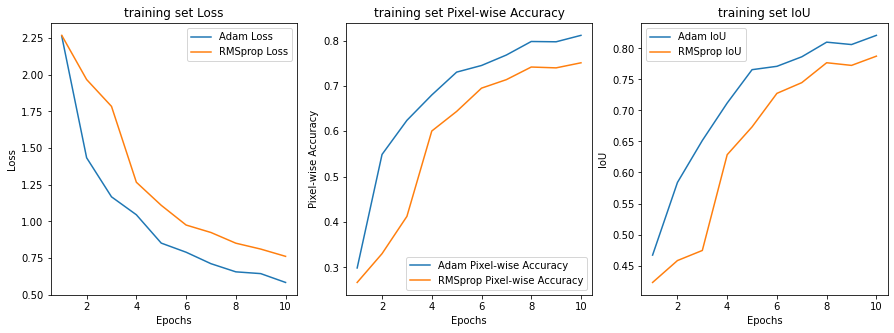

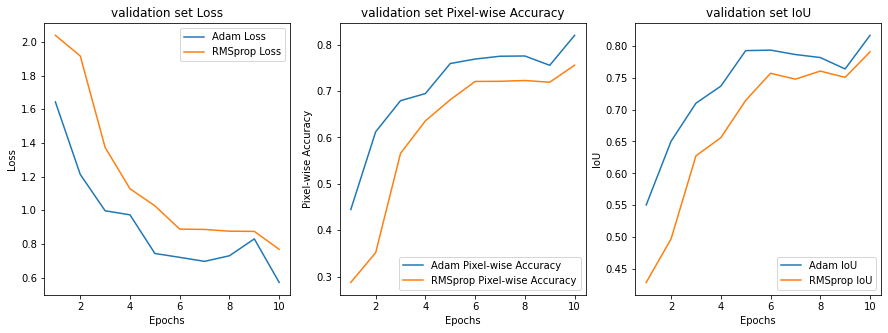

In [11]:
# Comparison for different optimizers of FCN16s model
input_model = FCN16s(num_classes)
optimizer = torch.optim.Adam(input_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma = 0.8)
train_losses1, valid_losses1, train_accuracies1, valid_accuracies1, train_ious1, valid_ious1 = train_validation(input_model,optimizer,scheduler,"1")

input_model = FCN16s(num_classes)
optimizer = torch.optim.RMSprop(input_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma = 0.8)
train_losses2, valid_losses2, train_accuracies2, valid_accuracies2, train_ious2, valid_ious2 = train_validation(input_model,optimizer,scheduler,"2")


plot_evaluation_metrics_graph(train_losses1, train_losses2, train_accuracies1, train_accuracies2, train_ious1, train_ious2,
                              "Adam", "RMSprop", "training set")
plot_evaluation_metrics_graph(valid_losses1, valid_losses2, valid_accuracies1, valid_accuracies2, valid_ious1, valid_ious2, 
                              "Adam", "RMSprop", "validation set")

Compare the perforamance between learning rate schedulers StepLR and MutiStepLR of FCN16s

Epoch 1/10:
training time: 178.29 seconds
Train Loss: 2.5416, Train Pixel-wise Accuracy: 0.2467, Train IoU: 0.4288
Valid Loss: 2.0920, Valid Pixel-wise Accuracy: 0.2605, Valid IoU: 0.4811
Epoch 2/10:
training time: 173.86 seconds
Train Loss: 1.9596, Train Pixel-wise Accuracy: 0.2830, Train IoU: 0.4997
Valid Loss: 1.8535, Valid Pixel-wise Accuracy: 0.3513, Valid IoU: 0.4426
Epoch 3/10:
training time: 177.75 seconds
Train Loss: 1.6028, Train Pixel-wise Accuracy: 0.4609, Train IoU: 0.5298
Valid Loss: 1.3472, Valid Pixel-wise Accuracy: 0.5452, Valid IoU: 0.5682
Epoch 4/10:
training time: 177.67 seconds
Train Loss: 1.1695, Train Pixel-wise Accuracy: 0.6129, Train IoU: 0.6493
Valid Loss: 1.1220, Valid Pixel-wise Accuracy: 0.6604, Valid IoU: 0.7022
Epoch 5/10:
training time: 177.44 seconds
Train Loss: 0.9881, Train Pixel-wise Accuracy: 0.6964, Train IoU: 0.7308
Valid Loss: 0.8813, Valid Pixel-wise Accuracy: 0.7320, Valid IoU: 0.7670
Epoch 6/10:
training time: 177.08 seconds
Train Loss: 0.8923

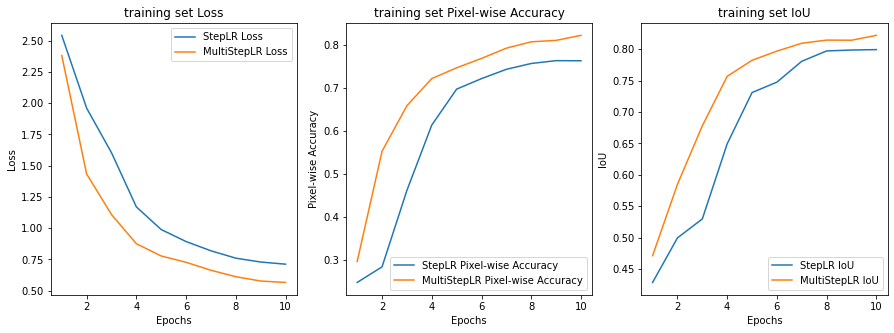

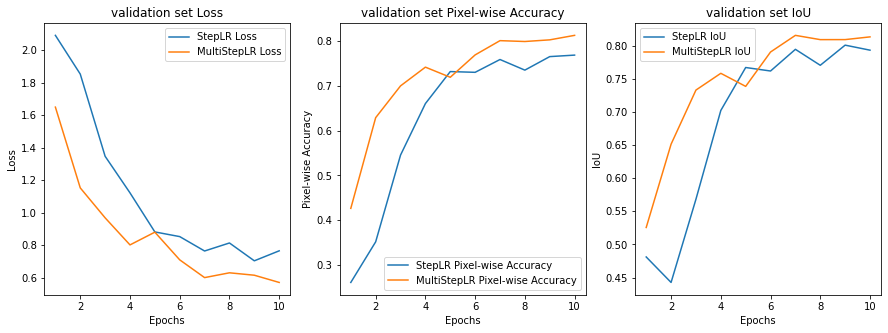

In [13]:
# Comparison for different learning rate schedulers of FCN16s model
input_model = FCN16s(num_classes)
optimizer = torch.optim.Adam(input_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma = 0.8)
train_losses1, valid_losses1, train_accuracies1, valid_accuracies1, train_ious1, valid_ious1 = train_validation(input_model,optimizer,scheduler,"1")

input_model = FCN16s(num_classes)
optimizer = torch.optim.Adam(input_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,6], gamma=0.5, last_epoch=-1)
train_losses2, valid_losses2, train_accuracies2, valid_accuracies2, train_ious2, valid_ious2 = train_validation(input_model,optimizer,scheduler,"2")


plot_evaluation_metrics_graph(train_losses1, train_losses2, train_accuracies1, train_accuracies2, train_ious1, train_ious2,
                                "StepLR", "MultiStepLR", "training set")
plot_evaluation_metrics_graph(valid_losses1, valid_losses2, valid_accuracies1, valid_accuracies2, valid_ious1, valid_ious2, 
                                "StepLR", "MultiStepLR", "validation set")

Compare the perforamance between optimizers ADAM and RMSprop of UNet

Epoch 1/10:
training time: 131.89 seconds
Train Loss: 2.3115, Train Pixel-wise Accuracy: 0.6512, Train IoU: 0.7233
Valid Loss: 2.2736, Valid Pixel-wise Accuracy: 0.6072, Valid IoU: 0.7189
Epoch 2/10:
training time: 131.49 seconds
Train Loss: 1.6948, Train Pixel-wise Accuracy: 0.8017, Train IoU: 0.8075
Valid Loss: 1.8509, Valid Pixel-wise Accuracy: 0.7401, Valid IoU: 0.7588
Epoch 3/10:
training time: 131.62 seconds
Train Loss: 1.4051, Train Pixel-wise Accuracy: 0.8473, Train IoU: 0.8406
Valid Loss: 1.3947, Valid Pixel-wise Accuracy: 0.8347, Valid IoU: 0.8384
Epoch 4/10:
training time: 131.67 seconds
Train Loss: 1.2537, Train Pixel-wise Accuracy: 0.8622, Train IoU: 0.8565
Valid Loss: 1.2330, Valid Pixel-wise Accuracy: 0.8605, Valid IoU: 0.8601
Epoch 5/10:
training time: 132.15 seconds
Train Loss: 1.1414, Train Pixel-wise Accuracy: 0.8830, Train IoU: 0.8727
Valid Loss: 1.0827, Valid Pixel-wise Accuracy: 0.8903, Valid IoU: 0.8851
Epoch 6/10:
training time: 132.15 seconds
Train Loss: 1.0824

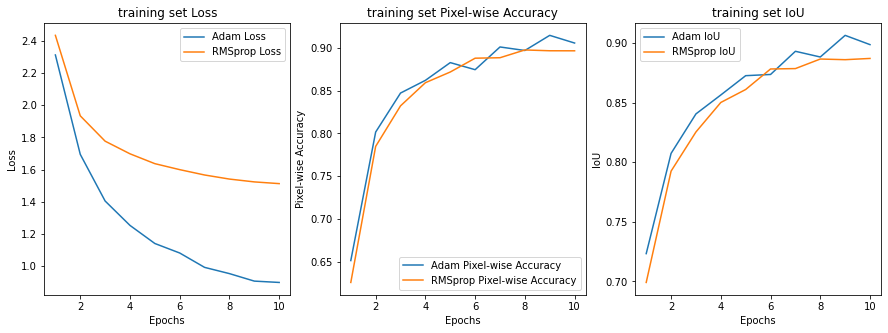

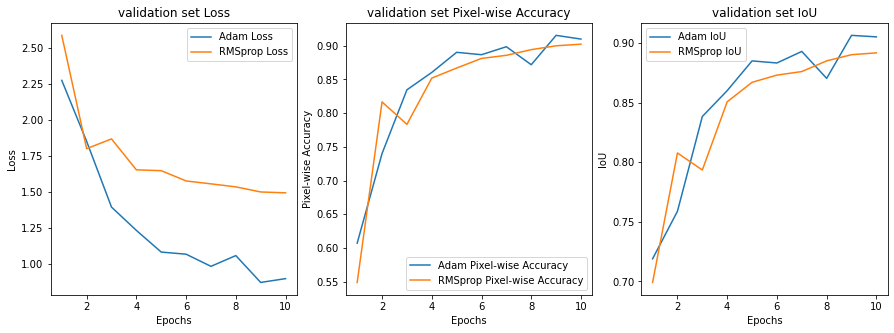

In [15]:
# unet optimizer
input_model = UNet(3, num_classes)
optimizer = torch.optim.Adam(input_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma = 0.8)
train_losses1, valid_losses1, train_accuracies1, valid_accuracies1, train_ious1, valid_ious1 = train_validation(input_model,optimizer,scheduler,"1")

input_model = UNet(3, num_classes)
optimizer = torch.optim.RMSprop(input_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma = 0.8)
train_losses2, valid_losses2, train_accuracies2, valid_accuracies2, train_ious2, valid_ious2 = train_validation(input_model,optimizer,scheduler,"2")


plot_evaluation_metrics_graph(train_losses1, train_losses2, train_accuracies1, train_accuracies2, train_ious1, train_ious2,
                              "Adam", "RMSprop", "training set")
plot_evaluation_metrics_graph(valid_losses1, valid_losses2, valid_accuracies1, valid_accuracies2, valid_ious1, valid_ious2, 
                              "Adam", "RMSprop", "validation set")

Compare the perforamance between learning rate schedulers StepLR and MutiStepLR of UNet

Epoch 1/10:
training time: 137.41 seconds
Train Loss: 2.2558, Train Pixel-wise Accuracy: 0.6974, Train IoU: 0.7456
Valid Loss: 2.1748, Valid Pixel-wise Accuracy: 0.6432, Valid IoU: 0.6981
Epoch 2/10:
training time: 139.27 seconds
Train Loss: 1.6947, Train Pixel-wise Accuracy: 0.7955, Train IoU: 0.8040
Valid Loss: 1.7915, Valid Pixel-wise Accuracy: 0.7516, Valid IoU: 0.7828
Epoch 3/10:
training time: 139.20 seconds
Train Loss: 1.4130, Train Pixel-wise Accuracy: 0.8449, Train IoU: 0.8406
Valid Loss: 1.3717, Valid Pixel-wise Accuracy: 0.8473, Valid IoU: 0.8379
Epoch 4/10:
training time: 138.48 seconds
Train Loss: 1.2472, Train Pixel-wise Accuracy: 0.8667, Train IoU: 0.8599
Valid Loss: 1.2660, Valid Pixel-wise Accuracy: 0.8535, Valid IoU: 0.8437
Epoch 5/10:
training time: 139.38 seconds
Train Loss: 1.1558, Train Pixel-wise Accuracy: 0.8822, Train IoU: 0.8730
Valid Loss: 1.1232, Valid Pixel-wise Accuracy: 0.8846, Valid IoU: 0.8799
Epoch 6/10:
training time: 139.11 seconds
Train Loss: 1.0588

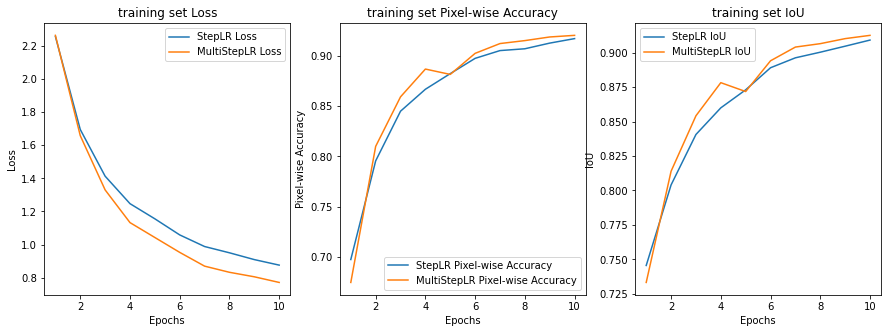

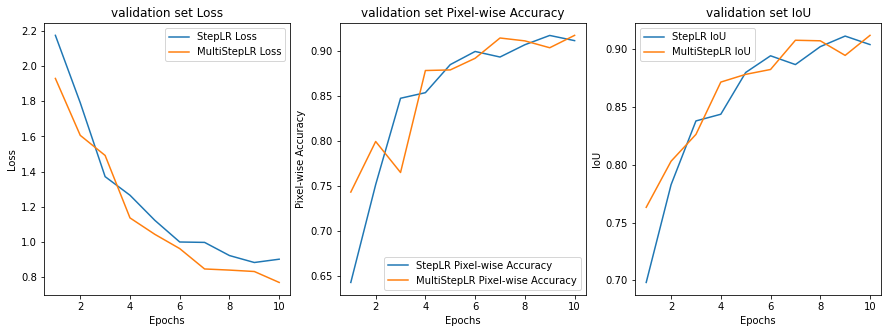

In [16]:
# Comparison for different learning rate schedulers of UNet
input_model = UNet(3, num_classes)
optimizer = torch.optim.Adam(input_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma = 0.8)
train_losses1, valid_losses1, train_accuracies1, valid_accuracies1, train_ious1, valid_ious1 = train_validation(input_model,optimizer,scheduler,"1")

input_model = UNet(3, num_classes)
optimizer = torch.optim.Adam(input_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,6], gamma=0.5, last_epoch=-1)
train_losses2, valid_losses2, train_accuracies2, valid_accuracies2, train_ious2, valid_ious2 = train_validation(input_model,optimizer,scheduler,"2")


plot_evaluation_metrics_graph(train_losses1, train_losses2, train_accuracies1, train_accuracies2, train_ious1, train_ious2,
                                "StepLR", "MultiStepLR", "training set ")
plot_evaluation_metrics_graph(valid_losses1, valid_losses2, valid_accuracies1, valid_accuracies2, valid_ious1, valid_ious2, 
                                "StepLR", "MultiStepLR", "validation set ")

Compare the perforamance between optimizers ADAM and RMSprop of DeepLabV2

Epoch 1/10:
training time: 79.93 seconds
Train Loss: 1.1662, Train Pixel-wise Accuracy: 0.7254, Train IoU: 0.7551
Valid Loss: 0.8148, Valid Pixel-wise Accuracy: 0.7357, Valid IoU: 0.7665
Epoch 2/10:
training time: 81.13 seconds
Train Loss: 0.6220, Train Pixel-wise Accuracy: 0.8085, Train IoU: 0.8144
Valid Loss: 0.5871, Valid Pixel-wise Accuracy: 0.8140, Valid IoU: 0.8238
Epoch 3/10:
training time: 81.25 seconds
Train Loss: 0.5239, Train Pixel-wise Accuracy: 0.8378, Train IoU: 0.8367
Valid Loss: 0.5622, Valid Pixel-wise Accuracy: 0.8198, Valid IoU: 0.8289
Epoch 4/10:
training time: 85.34 seconds
Train Loss: 0.4668, Train Pixel-wise Accuracy: 0.8501, Train IoU: 0.8471
Valid Loss: 0.4758, Valid Pixel-wise Accuracy: 0.8488, Valid IoU: 0.8466
Epoch 5/10:
training time: 82.72 seconds
Train Loss: 0.4464, Train Pixel-wise Accuracy: 0.8572, Train IoU: 0.8528
Valid Loss: 0.4760, Valid Pixel-wise Accuracy: 0.8458, Valid IoU: 0.8430
Epoch 6/10:
training time: 82.68 seconds
Train Loss: 0.4285, Trai

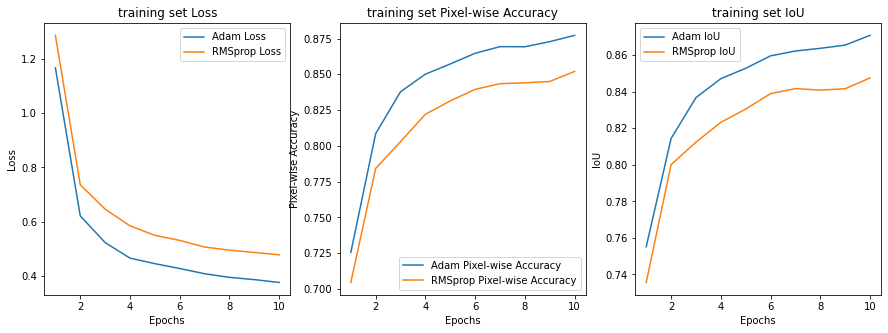

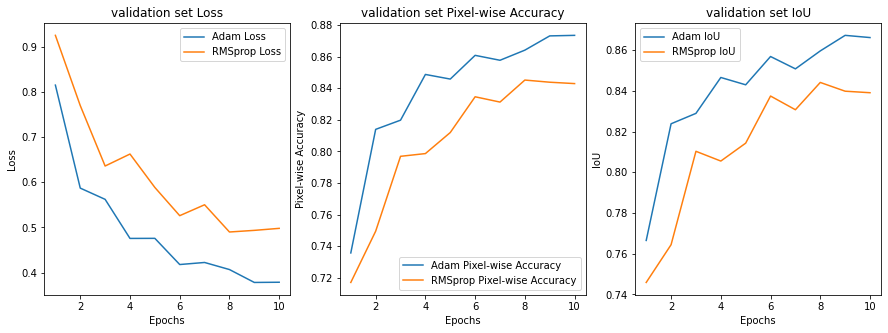

In [17]:
# deeplabv2 optimizer
input_model = DeepLabV2(num_classes)
optimizer = torch.optim.Adam(input_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma = 0.8)
train_losses1, valid_losses1, train_accuracies1, valid_accuracies1, train_ious1, valid_ious1 = train_validation(input_model,optimizer,scheduler,"1")

input_model = DeepLabV2(num_classes)
optimizer = torch.optim.RMSprop(input_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma = 0.8)
train_losses2, valid_losses2, train_accuracies2, valid_accuracies2, train_ious2, valid_ious2 = train_validation(input_model,optimizer,scheduler,"2")


plot_evaluation_metrics_graph(train_losses1, train_losses2, train_accuracies1, train_accuracies2, train_ious1, train_ious2,
                              "Adam", "RMSprop", "training set ")
plot_evaluation_metrics_graph(valid_losses1, valid_losses2, valid_accuracies1, valid_accuracies2, valid_ious1, valid_ious2, 
                              "Adam", "RMSprop", "validation set ")

Compare the perforamance between learning rate schedulers StepLR and MutiStepLR of DeepLabV2

Epoch 1/10:
training time: 82.33 seconds
Train Loss: 1.2268, Train Pixel-wise Accuracy: 0.7329, Train IoU: 0.7579
Valid Loss: 0.7087, Valid Pixel-wise Accuracy: 0.7780, Valid IoU: 0.7985
Epoch 2/10:
training time: 84.15 seconds
Train Loss: 0.6648, Train Pixel-wise Accuracy: 0.7969, Train IoU: 0.8111
Valid Loss: 0.6715, Valid Pixel-wise Accuracy: 0.7880, Valid IoU: 0.7823
Epoch 3/10:
training time: 83.16 seconds
Train Loss: 0.5565, Train Pixel-wise Accuracy: 0.8337, Train IoU: 0.8336
Valid Loss: 0.5368, Valid Pixel-wise Accuracy: 0.8320, Valid IoU: 0.8367
Epoch 4/10:
training time: 84.12 seconds
Train Loss: 0.4918, Train Pixel-wise Accuracy: 0.8493, Train IoU: 0.8464
Valid Loss: 0.4629, Valid Pixel-wise Accuracy: 0.8507, Valid IoU: 0.8513
Epoch 5/10:
training time: 83.56 seconds
Train Loss: 0.4550, Train Pixel-wise Accuracy: 0.8542, Train IoU: 0.8506
Valid Loss: 0.4572, Valid Pixel-wise Accuracy: 0.8501, Valid IoU: 0.8530
Epoch 6/10:
training time: 85.31 seconds
Train Loss: 0.4286, Trai

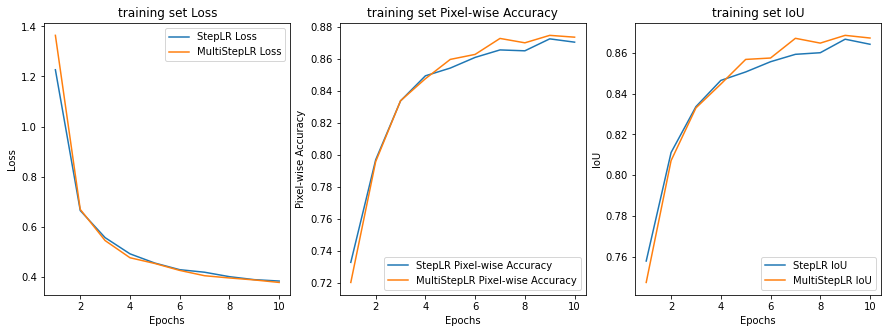

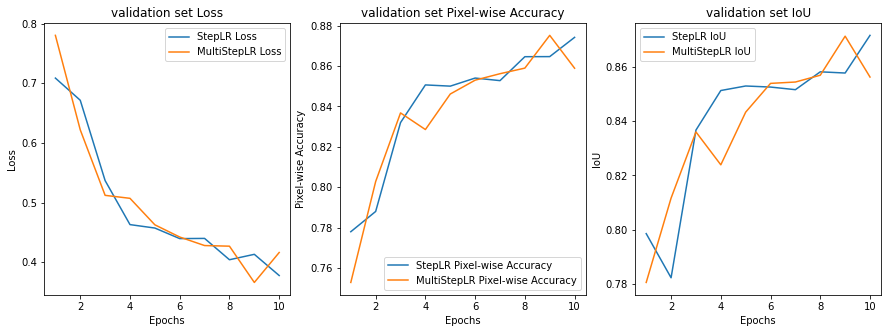

In [18]:
# DeepLabV2 scheduler
input_model = DeepLabV2(num_classes)
optimizer = torch.optim.Adam(input_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma = 0.8)
train_losses1, valid_losses1, train_accuracies1, valid_accuracies1, train_ious1, valid_ious1 = train_validation(input_model,optimizer,scheduler,"1")

input_model = DeepLabV2(num_classes)
optimizer = torch.optim.Adam(input_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,6], gamma=0.5, last_epoch=-1)
train_losses2, valid_losses2, train_accuracies2, valid_accuracies2, train_ious2, valid_ious2 = train_validation(input_model,optimizer,scheduler,"2")


plot_evaluation_metrics_graph(train_losses1, train_losses2, train_accuracies1, train_accuracies2, train_ious1, train_ious2,
                                "StepLR", "MultiStepLR", "training set ")
plot_evaluation_metrics_graph(valid_losses1, valid_losses2, valid_accuracies1, valid_accuracies2, valid_ious1, valid_ious2, 
                                "StepLR", "MultiStepLR", "validation set ")

In [19]:
# define test progress
def test_model(model):
    # set the model in evaluation mode
    model.eval()
    # initialize test accuracy and IoU score to zero
    test_acc, test_iou = 0, 0
    # initialize the number of batches to zero
    num_batches = 0
    
    # iterate over the test dataset
    with torch.no_grad():
        for images, labels in test_loader:
            # send the input and label tensors to the device (CPU or GPU)
            images = images.to(device)
            labels = labels.to(device).long()
            
            # forward pass through the model to get predictions
            outputs = model(images)
            
            # update the test accuracy and IoU score with the current batch
            test_acc += pixel_accuracy(outputs, labels)
            test_iou += iou_score(outputs, labels)
            num_batches += 1
    
    # compute the average test accuracy and IoU score over all batches
    test_acc /= num_batches
    test_iou /= num_batches
    
    # return the test accuracy and IoU score
    return test_acc, test_iou

def visualize_predictions(images, labels, pre1, pre2, pre3, num_images=2):
    # create a dictionary to map class indices to RGB values
    index_colors = {idx: rgb for idx, (rgb, label) in enumerate(label_colors.items())}
    
    # iterate over a subset of the input images
    for i in range(num_images):
        # create a figure with 5 subplots (input image, ground truth, and predictions from all 3 models)
        fig, ax = plt.subplots(1, 5, figsize=(20, 5))
        # show the input image in the first subplot
        ax[0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        ax[0].set_title("Input Image")
        
        # convert the label tensor to an RGB image using the index_colors dictionary, and show it in the second subplot
        label_rgb = np.zeros(tuple(labels[i].shape) + (3,), dtype=np.uint8)
        for idx, rgb in index_colors.items():
            label_rgb[(labels[i].cpu().numpy() == idx)] = rgb
        ax[1].imshow(label_rgb)
        ax[1].set_title("Ground Truth")
        
        # get the predictions of the FCN16s model, convert them to RGB images, and show them in the third subplot
        preds1 = torch.argmax(pre1, dim=1)
        pred_rgb1 = np.zeros(tuple(preds1[i].shape) + (3,), dtype=np.uint8)
        for idx, rgb in index_colors.items():
            pred_rgb1[(preds1[i].cpu().numpy() == idx)] = rgb
        ax[2].imshow(pred_rgb1)
        ax[2].set_title("FCN16s Prediction")
        
        # get the predictions of the UNet model, convert them to RGB images, and show them in the forth subplot
        preds2 = torch.argmax(pre2, dim=1)
        pred_rgb2 = np.zeros(tuple(preds2[i].shape) + (3,), dtype=np.uint8)
        for idx, rgb in index_colors.items():
            pred_rgb2[(preds2[i].cpu().numpy() == idx)] = rgb
        ax[3].imshow(pred_rgb2)
        ax[3].set_title("UNet Prediction")
        
        # get the predictions of the DeepLabV2 model, convert them to RGB images, and show them in the fifth subplot
        preds3 = torch.argmax(pre3, dim=1)
        pred_rgb3 = np.zeros(tuple(preds3[i].shape) + (3,), dtype=np.uint8)
        for idx, rgb in index_colors.items():
            pred_rgb3[(preds3[i].cpu().numpy() == idx)] = rgb
        ax[4].imshow(pred_rgb3)
        ax[4].set_title("DeepLabV2 Prediction")

FCN16s Model Test Pixel-wise Accuracy: 0.8645, Test Mean IoU: 0.8556
UNet Model Test Pixel-wise Accuracy: 0.9383, Test Mean IoU: 0.9313
DeepLabV2 Model Test Pixel-wise Accuracy: 0.8986, Test Mean IoU: 0.8868


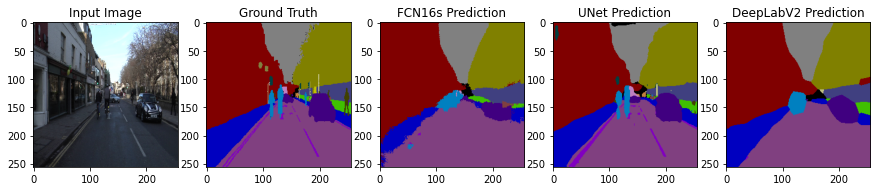

In [22]:
# initialize an instance of the FCN16s model with the given number of output classes
fcn_best_model = FCN16s(num_classes)
# load the pretrained weights for the FCN16s model from the "fcn_best_model.pt" file
fcn_best_model = torch.load("./fcn_best_model.pt")
# evaluate the FCN16s model on the test set and returns the pixel-wise accuracy and mean IoU
test_acc1, test_iou1 = test_model(fcn_best_model)
# initialize an instance of the UNet model with 3 input channels and the given number of output classes
unet_best_model = UNet(3,num_classes)
# loads the pretrained weights for the UNet model from the "unet_best_model.pt" file.
unet_best_model = torch.load("./unet_best_model.pt")
# evaluate the UNet model on the test set and returns the pixel-wise accuracy and mean IoU
test_acc2, test_iou2 = test_model(unet_best_model)
# initialize an instance of the DeepLabV2 model with the given number of output classes
deeplabv2_best_model = DeepLabV2(num_classes)
# load the pretrained weights for the DeepLabV2 model from the "deeplabv2_best_model.pt" file
deeplabv2_best_model = torch.load("./deeplabv2_best_model.pt")
# evaluate the DeepLabV2 model on the test set and returns the pixel-wise accuracy and mean IoU
test_acc3, test_iou3 = test_model(deeplabv2_best_model)

# print the result
print(f"FCN16s Model Test Pixel-wise Accuracy: {test_acc1:.4f}, Test Mean IoU: {test_iou1:.4f}")
print(f"UNet Model Test Pixel-wise Accuracy: {test_acc2:.4f}, Test Mean IoU: {test_iou2:.4f}")
print(f"DeepLabV2 Model Test Pixel-wise Accuracy: {test_acc3:.4f}, Test Mean IoU: {test_iou3:.4f}")

# start a context manager for disabling gradient computation
with torch.no_grad():
    # get the next batch of images and labels from the test data loader
    test_images, test_labels = next(iter(test_loader))
    # move the test images and labels to the specified device
    test_images = test_images.to(device)
    test_labels = test_labels.to(device).long()
    
    # passe the test images to the three models
    test_outputs1 = fcn_best_model(test_images)
    test_outputs2 = unet_best_model(test_images)
    test_outputs3 = deeplabv2_best_model(test_images)
    
    # visualize the result
    visualize_predictions(test_images, test_labels, test_outputs1, test_outputs2, test_outputs3)
